In [1]:
import warnings 
warnings.filterwarnings("ignore")

# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   ph                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11 

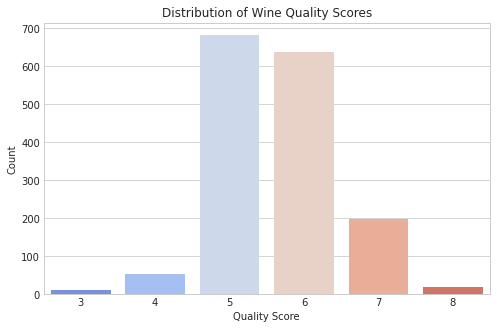


Note: 'quality' is an ordinal variable (scores 3-8 or similar). We'll treat it as continuous for regression,
but this can affect residual patterns. Most wines are of average quality (5 or 6).

Missing values per column:
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Data split into training and testing sets: X_train_all: (1279, 11), X_test_all: (320, 11)


In [5]:
# --- 0. SETUP & INITIAL EXPLORATION ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler # Added StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
wine_df = pd.read_csv("./data/winequality.csv")

# Clean column names (important for consistency)
wine_df.columns = wine_df.columns.str.replace(' ', '_').str.lower()
print(wine_df.columns)
wine_df.info()

# Explore the target variable 'quality'
plt.figure(figsize=(8, 5))

sns.countplot(x='quality', data=wine_df, palette="coolwarm")
plt.title('Distribution of Wine Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()
print("\nNote: 'quality' is an ordinal variable (scores 3-8 or similar). We'll treat it as continuous for regression,")
print("but this can affect residual patterns. Most wines are of average quality (5 or 6).")

# Check for missing values
print("\nMissing values per column:")
print(wine_df.isnull().sum())

# Define features (X) and target (y) - using all features initially for train/test split
X_all_features = wine_df.drop('quality', axis=1)
y_target = wine_df['quality']

# Split data into training and testing sets
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all_features, y_target, test_size=0.2, random_state=42)
print(f"\nData split into training and testing sets: X_train_all: {X_train_all.shape}, X_test_all: {X_test_all.shape}")



--- Section 1: Recap of Simple Linear Regression ---
Goal: Predict wine 'quality' using 'alcohol' content.

Simple Linear Model: quality = 1.85 + 0.36 * alcohol
Test R-squared: 0.236
Test Mean Squared Error: 0.500


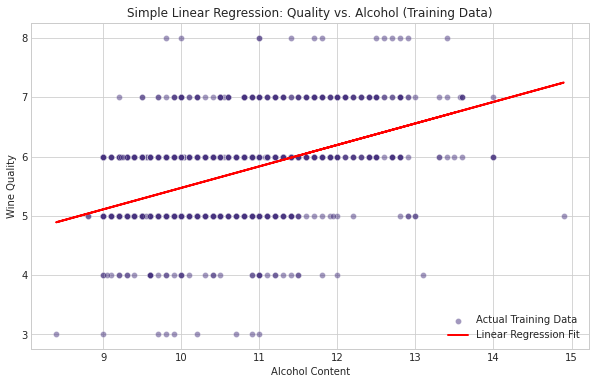

Discussion: 'Alcohol' generally shows a positive linear trend with quality.


In [7]:
# --- 1. RECAP OF LINEAR REGRESSION ---
print("\n\n--- Section 1: Recap of Simple Linear Regression ---")
print("Goal: Predict wine 'quality' using 'alcohol' content.")

# Select 'alcohol' for this simple model from the training data
X_train_simple = X_train_all[['alcohol']]
X_test_simple = X_test_all[['alcohol']]

# Fit the Linear Regression model
model_simple_linear = LinearRegression()
model_simple_linear.fit(X_train_simple, y_train)

# Coefficients
slope_simple = model_simple_linear.coef_[0]
intercept_simple = model_simple_linear.intercept_
print(f"\nSimple Linear Model: quality = {intercept_simple:.2f} + {slope_simple:.2f} * alcohol")

# Predictions on the TEST set
y_pred_simple_test = model_simple_linear.predict(X_test_simple)

# Evaluate on TEST set
r2_simple_test = r2_score(y_test, y_pred_simple_test)
mse_simple_test = mean_squared_error(y_test, y_pred_simple_test)
print(f"Test R-squared: {r2_simple_test:.3f}")
print(f"Test Mean Squared Error: {mse_simple_test:.3f}")

# Visualize on TRAINING data (to show the fit where it learned)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_simple['alcohol'], y=y_train, alpha=0.5, label='Actual Training Data')
plt.plot(X_train_simple['alcohol'], model_simple_linear.predict(X_train_simple), color='red', linewidth=2, label='Linear Regression Fit')
plt.title('Simple Linear Regression: Quality vs. Alcohol (Training Data)')
plt.xlabel('Alcohol Content')
plt.ylabel('Wine Quality')
plt.legend()
plt.show()
print("Discussion: 'Alcohol' generally shows a positive linear trend with quality.")



--- Section 2: Polynomial Regression ---
Goal: Model non-linear relationship. E.g., 'volatile_acidity' impact on 'quality'.
Volatile acidity is generally bad, but its negative impact might not be linear.
Polynomial features (degree 2): ['volatile_acidity' 'volatile_acidity^2']

Polynomial Model (degree 2) using 'volatile_acidity':
Test R-squared: 0.186
Test Mean Squared Error: 0.532
(Compare with Simple Linear R-squared on alcohol: 0.236)


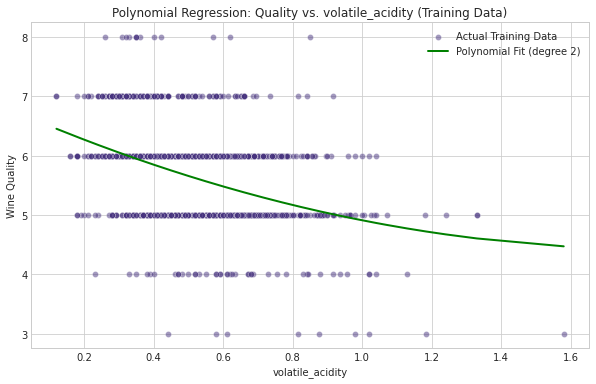

Discussion: Does the curve capture the trend better? Consider if R-squared improved.
Risk of overfitting with high degrees! Degree 2-3 is common to try.


In [8]:
# --- 2. POLYNOMIAL REGRESSION ---
print("\n\n--- Section 2: Polynomial Regression ---")
print("Goal: Model non-linear relationship. E.g., 'volatile_acidity' impact on 'quality'.")
print("Volatile acidity is generally bad, but its negative impact might not be linear.")

# Select 'volatile_acidity' for this example
feature_for_poly = 'volatile_acidity'
X_train_poly_feature = X_train_all[[feature_for_poly]]
X_test_poly_feature = X_test_all[[feature_for_poly]]

# Create Polynomial Features (e.g., degree 2 or 3)
degree = 2
poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_transformer.fit_transform(X_train_poly_feature)
X_test_poly = poly_transformer.transform(X_test_poly_feature) # Use transform only on test data

# Feature names for the polynomial features
poly_feature_names = poly_transformer.get_feature_names_out([feature_for_poly])
print(f"Polynomial features (degree {degree}): {poly_feature_names}")

# Fit a linear regression model to these polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Predictions on the TEST set
y_pred_poly_test = model_poly.predict(X_test_poly)

# Evaluate on TEST set
r2_poly_test = r2_score(y_test, y_pred_poly_test)
mse_poly_test = mean_squared_error(y_test, y_pred_poly_test)
print(f"\nPolynomial Model (degree {degree}) using '{feature_for_poly}':")
print(f"Test R-squared: {r2_poly_test:.3f}")
print(f"Test Mean Squared Error: {mse_poly_test:.3f}")
print(f"(Compare with Simple Linear R-squared on alcohol: {r2_simple_test:.3f})")

# Visualize on TRAINING data for fit understanding
# Sort values for a smooth line plot
X_train_plot_sorted = X_train_poly_feature.sort_values(by=feature_for_poly)
X_train_poly_plot_sorted = poly_transformer.transform(X_train_plot_sorted)
y_pred_poly_train_sorted = model_poly.predict(X_train_poly_plot_sorted)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_poly_feature[feature_for_poly], y=y_train, alpha=0.5, label='Actual Training Data')
plt.plot(X_train_plot_sorted[feature_for_poly], y_pred_poly_train_sorted, color='green', linewidth=2, label=f'Polynomial Fit (degree {degree})')
plt.title(f'Polynomial Regression: Quality vs. {feature_for_poly} (Training Data)')
plt.xlabel(feature_for_poly)
plt.ylabel('Wine Quality')
plt.legend()
plt.show()
print("Discussion: Does the curve capture the trend better? Consider if R-squared improved.")
print("Risk of overfitting with high degrees 2-3 is common to try.")




--- Section 3: Diagnosing the Polynomial Model ---
Focus on residuals from the TRAINING data predictions.


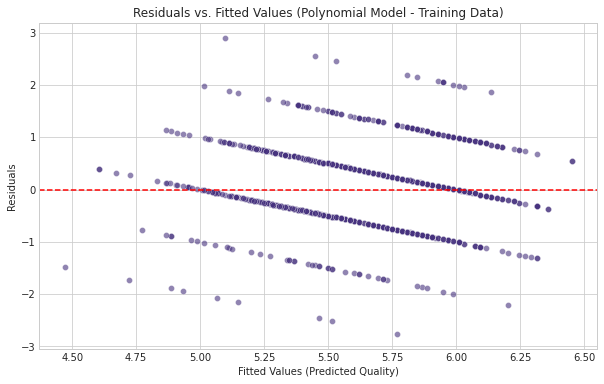


Look for: Random scatter around 0 (good).
Patterns like funnels (heteroscedasticity) or curves (misspecification) are bad.
Due to 'quality' being ordinal, you might see some horizontal banding in residuals – this is expected.


<Figure size 576x360 with 0 Axes>

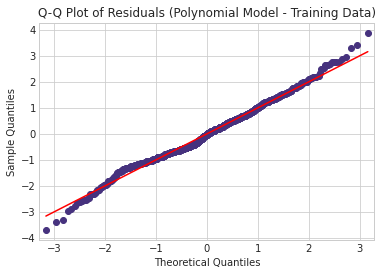


Look for: Points roughly following the diagonal line for normality.
Deviations at the tails are common.

Statsmodels OLS summary for Polynomial Model (Training Data):
                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     108.5
Date:                Tue, 20 May 2025   Prob (F-statistic):           3.05e-44
Time:                        13:07:33   Log-Likelihood:                -1439.5
No. Observations:                1279   AIC:                             2885.
Df Residuals:                    1276   BIC:                             2900.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err  

In [9]:
# --- 3. DIAGNOSE THE POLYNOMIAL MODEL ---
print("\n\n--- Section 3: Diagnosing the Polynomial Model ---")
print("Focus on residuals from the TRAINING data predictions.")

# Predictions on the training data for diagnostics
y_pred_poly_train = model_poly.predict(X_train_poly)
residuals_poly_train = y_train - y_pred_poly_train

# 1. Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_poly_train, y=residuals_poly_train, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values (Polynomial Model - Training Data)')
plt.xlabel('Fitted Values (Predicted Quality)')
plt.ylabel('Residuals')
plt.show()
print("\nLook for: Random scatter around 0 (good).")
print("Patterns like funnels (heteroscedasticity) or curves (misspecification) are bad.")
print("Due to 'quality' being ordinal, we might see some horizontal banding in residuals – this is expected.")

# 2. Q-Q Plot for Normality of Residuals
plt.figure(figsize=(8, 5))
sm.qqplot(residuals_poly_train, line='s', fit=True)
plt.title('Q-Q Plot of Residuals (Polynomial Model - Training Data)')
plt.show()
print("\nLook for: Points roughly following the diagonal line for normality.")
print("Deviations at the tails are common.")

# Using statsmodels for a more detailed summary (optional, but good)
# Create a DataFrame for statsmodels, including a constant
X_train_poly_df_sm = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train_poly_feature.index)
X_train_poly_df_sm_const = sm.add_constant(X_train_poly_df_sm) # Add intercept term
model_sm_poly = sm.OLS(y_train, X_train_poly_df_sm_const).fit()
print("\nStatsmodels OLS summary for Polynomial Model (Training Data):")
print(model_sm_poly.summary())
print("This gives p-values for coefficients, F-statistic, Durbin-Watson, etc.")



--- Section 4: Interaction Terms ---
Goal: Explore if the effect of one variable on quality depends on another.
Example: How does 'volatile_acidity' interact with 'sulphates' to affect 'quality'?
'Sulphates' might mitigate some negative effects of 'volatile_acidity'.

Interaction Model Coefficients:
Intercept: 5.656
Coeff volatile_acidity: -0.918
Coeff sulphates: 1.190
Coeff Interaction: -0.965

Interaction Model Test R-squared: 0.217
Interaction Model Test MSE: 0.512


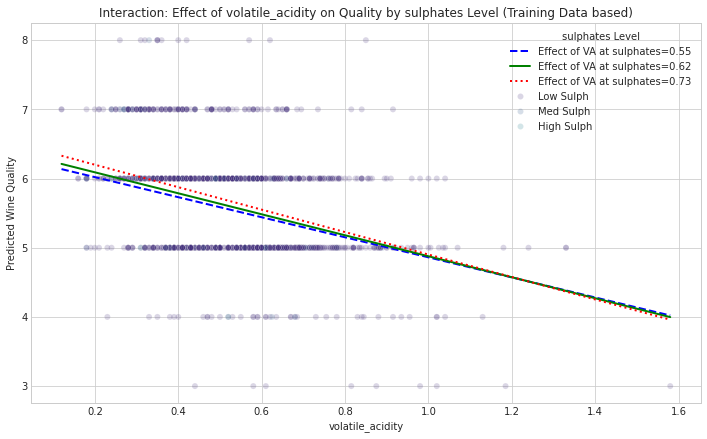


Discussion: If lines are not parallel, an interaction effect is present.
The slope of 'volatile_acidity' vs 'quality' changes depending on the 'sulphates' level.
A significant interaction coefficient also suggests this.
Diagnostics for this model would be similar to the polynomial model (residuals vs. fitted, Q-Q plot).


--- End of Enhanced Guided Project ---
Key Improvements and Takeaways:
1. Used Train/Test split for more reliable model evaluation.
2. Explored 'quality' distribution and acknowledged its ordinal nature.
3. Chose features ('volatile_acidity', 'sulphates') known for interesting effects in wine.
4. Emphasized interpreting diagnostics in context (e.g., banding in residuals).
5. Visualized interactions to make them more intuitive.


In [10]:
# --- 4. INTERACTION TERMS ---
print("\n\n--- Section 4: Interaction Terms ---")
print("Goal: Explore if the effect of one variable on quality depends on another.")
print("Example: How does 'volatile_acidity' interact with 'sulphates' to affect 'quality'?")
print("'Sulphates' might mitigate some negative effects of 'volatile_acidity'.")

# Select features for interaction
feature1 = 'volatile_acidity'
feature2 = 'sulphates'

# Prepare data with main effects and interaction term
X_train_inter = X_train_all[[feature1, feature2]].copy() # Use .copy() to avoid SettingWithCopyWarning
X_test_inter = X_test_all[[feature1, feature2]].copy()

X_train_inter['interaction_term'] = X_train_inter[feature1] * X_train_inter[feature2]
X_test_inter['interaction_term'] = X_test_inter[feature1] * X_test_inter[feature2]

# Fit a linear model
model_interaction = LinearRegression()
model_interaction.fit(X_train_inter, y_train)

# Coefficients
print(f"\nInteraction Model Coefficients:")
print(f"Intercept: {model_interaction.intercept_:.3f}")
print(f"Coeff {feature1}: {model_interaction.coef_[0]:.3f}")
print(f"Coeff {feature2}: {model_interaction.coef_[1]:.3f}")
print(f"Coeff Interaction: {model_interaction.coef_[2]:.3f}")

# Predictions on TEST set
y_pred_interaction_test = model_interaction.predict(X_test_inter)

# Evaluate on TEST set
r2_interaction_test = r2_score(y_test, y_pred_interaction_test)
mse_interaction_test = mean_squared_error(y_test, y_pred_interaction_test)
print(f"\nInteraction Model Test R-squared: {r2_interaction_test:.3f}")
print(f"Interaction Model Test MSE: {mse_interaction_test:.3f}")

# Visualizing Interactions
# Plot effect of 'volatile_acidity' at different levels of 'sulphates'
plt.figure(figsize=(12, 7))
# Define low, medium, high levels of 'sulphates' from training data
low_sulphates = X_train_all[feature2].quantile(0.25)
med_sulphates = X_train_all[feature2].median()
high_sulphates = X_train_all[feature2].quantile(0.75)

va_range = np.linspace(X_train_all[feature1].min(), X_train_all[feature1].max(), 50)

for sulph_level, color, linestyle in zip(
    [low_sulphates, med_sulphates, high_sulphates],
    ['blue', 'green', 'red'],
    ['--', '-', ':']
):
    # Create data for prediction: VA changes, Sulphates fixed, Interaction term calculated
    current_interaction_data = pd.DataFrame({
        feature1: va_range,
        feature2: sulph_level,
        'interaction_term': va_range * sulph_level
    })
    pred_quality = model_interaction.predict(current_interaction_data)
    plt.plot(va_range, pred_quality, label=f'Effect of VA at {feature2}={sulph_level:.2f}', color=color, linestyle=linestyle, linewidth=2)

sns.scatterplot(x=X_train_all[feature1], y=y_train, hue=pd.cut(X_train_all[feature2], bins=3, labels=['Low Sulph','Med Sulph','High Sulph']), alpha=0.2, legend='brief') # Show actual data points
plt.xlabel(feature1)
plt.ylabel('Predicted Wine Quality')
plt.title(f'Interaction: Effect of {feature1} on Quality by {feature2} Level (Training Data based)')
plt.legend(title=f'{feature2} Level')
plt.show()

print("\nDiscussion: If lines are not parallel, an interaction effect is present.")
print("The slope of 'volatile_acidity' vs 'quality' changes depending on the 'sulphates' level.")
print("A significant interaction coefficient also suggests this.")
print("Diagnostics for this model would be similar to the polynomial model (residuals vs. fitted, Q-Q plot).")